In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
sns.set(style='whitegrid',context='notebook')
plt.rcParams['figure.figsize'] = (5, 5)

height has been deprecated.



In [2]:
far_df = pd.read_csv('./datasets/firmannualreports.csv',index_col=0)
ptu_df = pd.read_csv('./datasets/processtechnologyuses.csv',index_col=0)
advisor_df = pd.read_csv('./datasets/advisor.csv',index_col=0)
client_df = pd.read_csv('./datasets/client.csv',index_col=0)
financial_df = pd.read_csv('./datasets/financial.csv',index_col=0)
frb_df = pd.read_csv('./datasets/financialrevenuebreakdown.csv',index_col=0)
foe_df = pd.read_csv('./datasets/financialoperatingexpenses.csv',index_col=0)
fs_df = pd.read_csv('./datasets/firmsection.csv',index_col=0)
owner_df = pd.read_csv('./datasets/owner.csv',index_col=0)
process_df = pd.read_csv('./datasets/process.csv',index_col=0)
rev_df = pd.read_csv('./datasets/revenue.csv',index_col=0)
results_df = pd.read_csv('./datasets/firmanalyticsresults.csv',index_col=0)
tech_df = pd.read_csv('./datasets/tech_rev_opex_ebitda_eboc.csv',index_col=0)

In [3]:
df = far_df.merge(fs_df,how='inner',left_on='firmsectionid',right_index=True)
df = df.merge(client_df,how='inner',left_on='clientid',right_index=True)
df = df.merge(rev_df,how='inner',left_on='revenueid',right_index=True)
df = df.merge(process_df.astype('int'),how='inner',left_on='processid',right_index=True)
df = df.merge(ptu_df.astype('int'),how='inner',left_on='processtechnologyuseid',right_index=True)
df = df.merge(financial_df,how='inner',left_on='financialsid',right_index=True)
df = df.merge(advisor_df,how='inner',left_index=True,right_on='firmannualreportid')
df = df.merge(owner_df.astype('float'),how='inner',left_index=True,right_on='firmannualreportid')
df = df.merge(frb_df,how='inner',left_on='RevenueBreakdownId',right_index=True)
df = df.merge(foe_df,how='inner',left_on='OperatingExpensesId',right_index=True)
df = df.merge(results_df,how='inner',left_on='firmanalyticsresultid',right_index=True)

In [91]:
cols = ptu_df.columns.tolist()
cols.append('NetRevenue')
df1 = df[cols].copy()
N = len(cols[:-1])
tech_fts = cols[:-1]

In [92]:
X = df1[cols[:-1]].values.reshape(-1,N)
y = df1['NetRevenue'].values.reshape(-1,1)

In [93]:
#cv = ShuffleSplit(n_splits=20, test_size=0.25, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=.2, random_state=42)

/Users/alexanderpan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R^2 Train: 0.64517, test: 0.43557
MSE Train: 6078626236884.65918, test: 7784294988081.16211


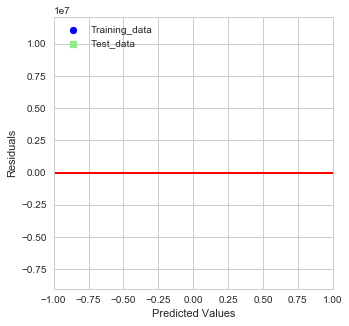

In [94]:
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=42,
                               n_jobs=-1,
                               oob_score=True)
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('R^2 Train: %.5f, test: %.5f' % (r2_score(y_train,y_train_pred),r2_score(y_test, y_test_pred)))

print('MSE Train: %.5f, test: %.5f' % (mean_squared_error(y_train,y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
plt.scatter(y_train_pred,(y_train_pred.reshape(-1,1)-y_train),c='blue',label='Training_data',marker='o')
plt.scatter(y_test_pred,(y_test_pred.reshape(-1,1)-y_test),c='lightgreen',marker='s',label='Test_data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
plt.xlim([-1,1])
plt.show()

In [95]:
fts = forest.feature_importances_
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = cols[:-1]
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

,type,feature_importance
7,socialmedia,0.279411
9,digitalcompliancemonitoring,0.167762
6,clientportal,0.139726
12,riskassessmentsoftware,0.082270
3,portfolioaccounting,0.074770
8,email,0.061270
1,accounting,0.058637
10,digitalfinancialrecords,0.037093
2,portfoliomanagement,0.035660
0,crm,0.026830


In [96]:
df1[cols[:-1]].sum()

crm                             949
accounting                      979
portfoliomanagement            1004
portfolioaccounting             750
financialplanning               984
firmwebsite                    1033
clientportal                    930
socialmedia                     654
email                           907
digitalcompliancemonitoring     778
digitalfinancialrecords         932
robotechnology                   30
riskassessmentsoftware          212
dtype: int64

In [97]:
#tech_df.loc[((tech_df[tech_fts]==1).sum(axis=1)==8) & 
#            ((tech_df['NetRevenue(>75)']==1) | tech_df['NetRevenue(51-75)']==1)].shape
temp = tech_df.loc[((tech_df['NetRevenue(>75)']==1) | tech_df['NetRevenue(51-75)']==1)]

In [98]:
X = temp[tech_fts].values.reshape(-1,N)
y = temp['NetRevenue(51-75)'].values.reshape(-1,1)
forest = RandomForestRegressor(n_estimators=100,criterion='mse',n_jobs=-1,oob_score=True)
forest.fit(X,y.reshape(-1))
y_pred = forest.predict(X)
print('MSE: %.5f, R^2: %.5f' % (mean_squared_error(y,y_pred),r2_score(y,y_pred)))

fts = forest.feature_importances_
cols = list(df1.iloc[:,2:N].columns)
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = tech_fts
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

MSE: 0.16145, R^2: 0.35421


,type,feature_importance
3,portfolioaccounting,0.116341
7,socialmedia,0.095499
4,financialplanning,0.094427
10,digitalfinancialrecords,0.086832
6,clientportal,0.084814
8,email,0.084337
9,digitalcompliancemonitoring,0.082278
1,accounting,0.074157
2,portfoliomanagement,0.069885
5,firmwebsite,0.069824


In [99]:
X = temp[tech_fts].values.reshape(-1,N)
y = temp['NetRevenue(>75)'].values.reshape(-1,1)
forest = RandomForestRegressor(n_estimators=100,criterion='mse',n_jobs=-1,oob_score=True)
forest.fit(X,y.reshape(-1))
y_pred = forest.predict(X)
print('MSE: %.5f, R^2: %.5f' % (mean_squared_error(y,y_pred),r2_score(y,y_pred)))

fts = forest.feature_importances_
cols = list(df1.iloc[:,2:N].columns)
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = tech_fts
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

MSE: 0.16158, R^2: 0.35369


,type,feature_importance
3,portfolioaccounting,0.116719
10,digitalfinancialrecords,0.095101
4,financialplanning,0.094755
7,socialmedia,0.093523
8,email,0.082947
6,clientportal,0.082229
9,digitalcompliancemonitoring,0.082065
1,accounting,0.074505
5,firmwebsite,0.066683
12,riskassessmentsoftware,0.064692


In [87]:
tech_df.sum().astype('int')

crm                                   635
accounting                            567
portfoliomanagement                   601
portfolioaccounting                   389
financialplanning                     582
firmwebsite                           629
clientportal                          598
socialmedia                           434
email                                 579
digitalcompliancemonitoring           445
digitalfinancialrecords               536
robotechnology                         29
riskassessmentsoftware                150
NetRevenue                     1130332412
OperatingExpenses               640728314
Ebitda                          520629075
Eboc                            723976208
NetRevenue(<=25)                      188
NetRevenue(26-50)                     187
NetRevenue(51-75)                     187
NetRevenue(>75)                       188
OpExpenses(<=25)                      188
OpExpenses(26-50)                     188
OpExpenses(51-75)                 

In [90]:
X = tech_df[tech_fts].values.reshape(-1,N)
y = tech_df['NetRevenue(<=25)'].values.reshape(-1,1)
forest = RandomForestRegressor(n_estimators=100,criterion='mse',n_jobs=-1,oob_score=True)
forest.fit(X,y.reshape(-1))
y_pred = forest.predict(X)
print('MSE: %.5f, R^2: %.5f' % (mean_squared_error(y,y_pred),r2_score(y,y_pred)))

fts = forest.feature_importances_
cols = list(df1.iloc[:,2:N].columns)
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = tech_fts
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

MSE: 0.09641, R^2: 0.48670


,type,feature_importance
5,firmwebsite,0.162644
1,accounting,0.088079
0,crm,0.084154
9,digitalcompliancemonitoring,0.078272
3,portfolioaccounting,0.078150
10,digitalfinancialrecords,0.077759
6,clientportal,0.075423
12,riskassessmentsoftware,0.073811
7,socialmedia,0.071457
8,email,0.067600
